### Imports e Configurações

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf

from datetime import datetime, timedelta, timezone

from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import kstest_normal,het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import acf, q_stat, adfuller, kpss

from scipy.stats import probplot, moment, shapiro, jarque_bera

import pmdarima as pm

In [4]:
seed = 2022 

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
img_dir = os.path.join('..', 'img')

### Funções Uteis

In [7]:
# Calcular a volatilidade realizada diaria
def realized_volatility_daily(series_log_return):
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    # return np.sqrt(np.sum(series_log_return**2))
# Calcular a volatilidade realizada diaria
def realized_volatility(series_log_return):
    n = len(series_log_return)
    # return np.sqrt(np.sum(series_log_return**2)/(n - 1))
    return np.sqrt(np.sum(series_log_return**2))

def transform_volatility_to_scaler(scaler, tf_series):
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output


In [8]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def RMSE(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))  
     
def MAPE(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred) 

In [9]:
def get_resid_garch(model):
    gm_resid = model.resid
    gm_std = model.conditional_volatility
    return gm_resid / gm_std

def pvalue_ljungbox(values):
    return acorr_ljungbox(values, lags=[10]).lb_pvalue.iloc[0]

def pvalue_het_arch(values):
    return het_arch(values)[1]

def pvalue_shapiro(values):
    return shapiro(values)[1]

In [10]:
perf_df = pd.DataFrame(columns=['Validation RMSPE', 'Validation RMSE', "MAPE"])
analysis_df = pd.DataFrame(columns=['AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

def log_perf(y_true, y_pred, model_name):
    perf_df.loc[model_name] = [
        RMSPE(y_true, y_pred), 
         RMSE(y_true, y_pred), 
         MAPE(y_true, y_pred)
    ]
    return perf_df

def log_garch(model, model_name, isNormal = True):
    analysis_df.loc[model_name] = [
        model.aic,
        model.bic,
        pvalue_ljungbox(get_resid_garch(model)),
        pvalue_ljungbox(get_resid_garch(model)**2),
        pvalue_het_arch(get_resid_garch(model)),
        pvalue_shapiro(get_resid_garch(model)) if isNormal else 0
    ]
    return analysis_df

def reset_log_garch():
    analysis_df = pd.DataFrame(columns=[ 'AIC', 'BIC', 'LB', 'LB(r²)', 'ARCH', 'SW'])

In [11]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [12]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

In [13]:
### GARCH FUNTIONS
def scale_tf_cond_vol(model_result):
    cond_vol = model_result.conditional_volatility
    scaler = StandardScaler()
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))
    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

### Analise Exploratória 

In [14]:
start = datetime(2015, 1, 1)
end = datetime(2022, 10, 1)
start_covid = datetime(2020,2,20)
end_covid = datetime(2021, 1, 1)

In [15]:
ticker_name = "^BVSP"
ticker = yf.Ticker(ticker_name)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

In [16]:
## Interpolar Time series (Preencher valores nulos)
date_range = pd.date_range(
    start=start, 
    end=end,
    freq='D'
  )
data = df.reset_index()
data['Date'] = data['Date'].astype('datetime64[ns]')
data_aux = pd.DataFrame({'Date': date_range })
data = pd.merge(data_aux, data, on='Date', how='left')
data = data.set_index(["Date"], drop=True)  
data.interpolate(method='linear', inplace=True)
data = df.reset_index()
data['Date'] =data['Date'].apply(lambda x: x.replace(tzinfo=None))
data_aux = pd.DataFrame({'Date': date_range })
data = pd.merge(data_aux, data, on='Date', how='left')
data = data.set_index(["Date"], drop=True)  
data.interpolate(method='linear', inplace=True)


In [17]:
data = data.dropna()

In [18]:
df = data

Inserir Variavies Dummy

In [19]:
df['covid'] = df.index.map(lambda date : 1 if start_covid < date or date > end_covid else 0)

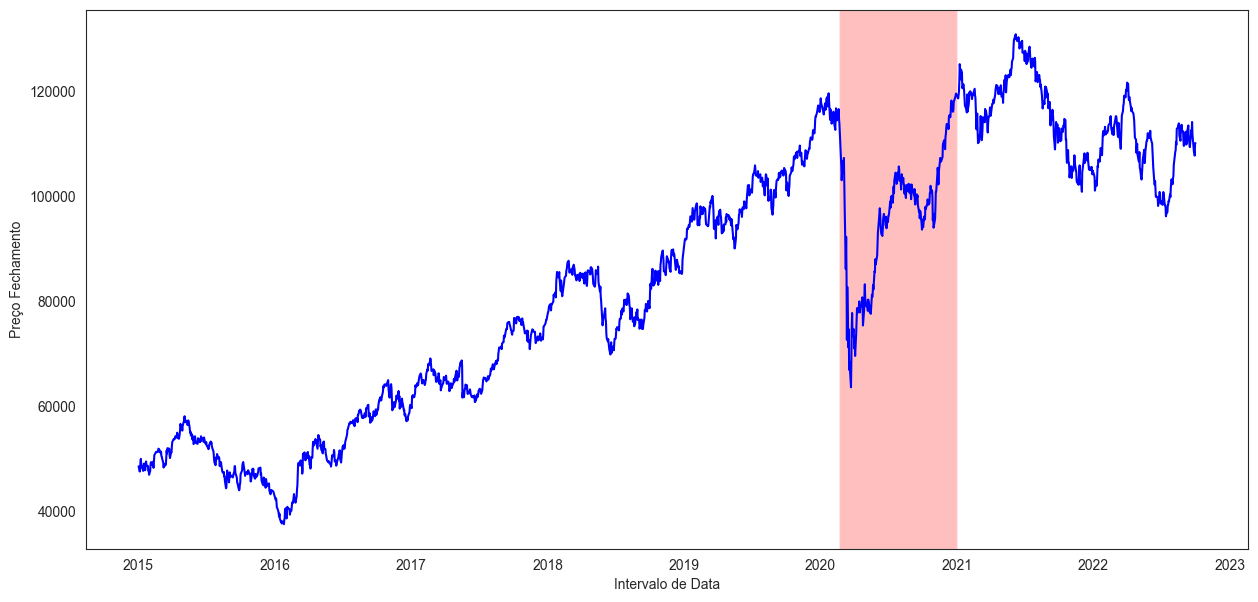

In [20]:
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(15,7))
    ax1.plot(df.Close, color='blue', label='Preço Fechamento')  
    plt.xlabel('Intervalo de Data')
    plt.ylabel('Preço Fechamento')
    ax1.axvspan(start_covid,end_covid, facecolor='red', alpha=0.25)
    plt.show()


In [21]:
df['returns'] = 100 * df['Close'].pct_change().dropna()

LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

In [22]:
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))

In [23]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns
Date,,,,,,,,,,
2015-01-02,50005.000000,50005.000000,48345.000000,48512.000000,2882100.0,0.0,0.0,0,NaN,NaN
2015-01-03,49507.333333,49507.333333,47984.666667,48180.333333,3210100.0,0.0,0.0,0,-0.683680,-0.006860
2015-01-04,49009.666667,49009.666667,47624.333333,47848.666667,3538100.0,0.0,0.0,0,-0.688386,-0.006908


In [24]:
df.dropna(inplace=True)

In [25]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns
Date,,,,,,,,,,
2015-01-03,49507.333333,49507.333333,47984.666667,48180.333333,3210100.0,0.0,0.0,0,-0.683680,-0.006860
2015-01-04,49009.666667,49009.666667,47624.333333,47848.666667,3538100.0,0.0,0.0,0,-0.688386,-0.006908
2015-01-05,48512.000000,48512.000000,47264.000000,47517.000000,3866100.0,0.0,0.0,0,-0.693158,-0.006956


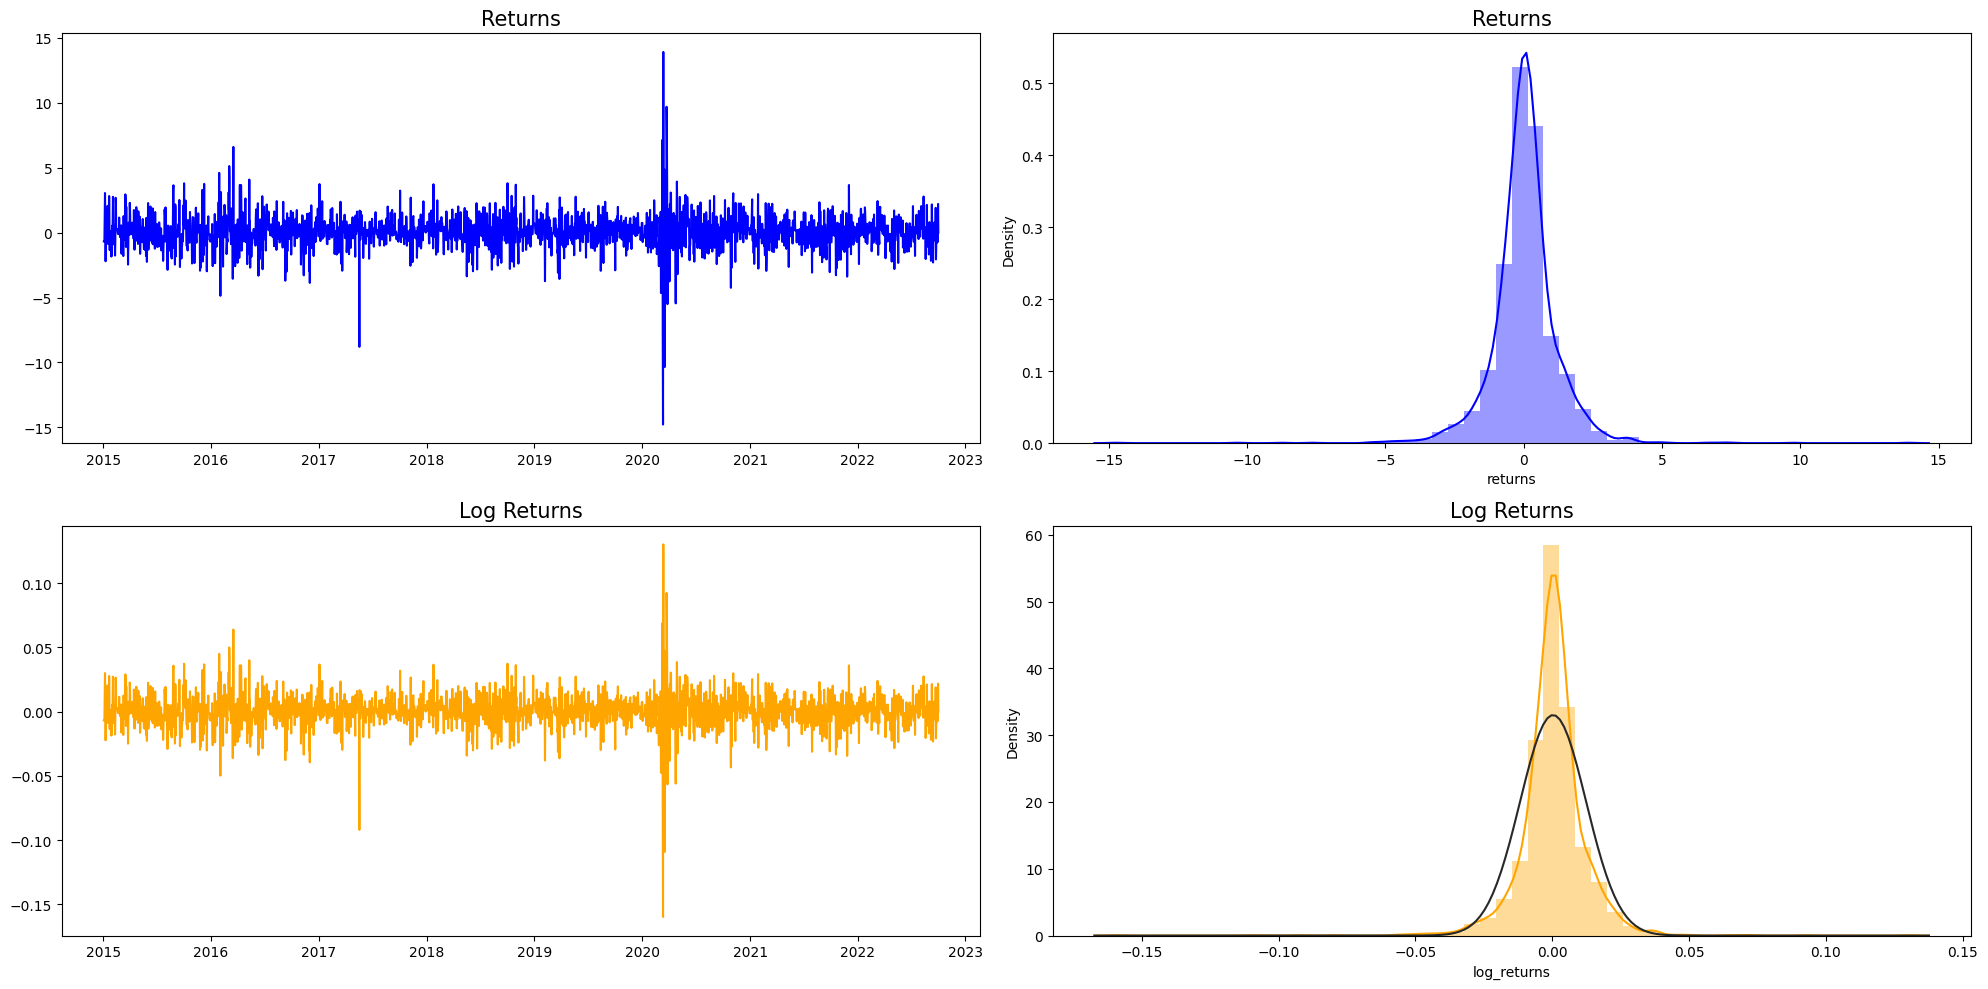

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df['returns'], color='blue')
axes[0][0].set_title('Returns', fontsize=15)

sns.distplot(df['returns'],  color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns', fontsize=15)

axes[1][0].plot(df['log_returns'], color='orange')
axes[1][0].set_title('Log Returns', fontsize=15)

sns.distplot(df['log_returns'], norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'returns.jpg'), dpi=300, bbox_inches='tight')
fig.show();

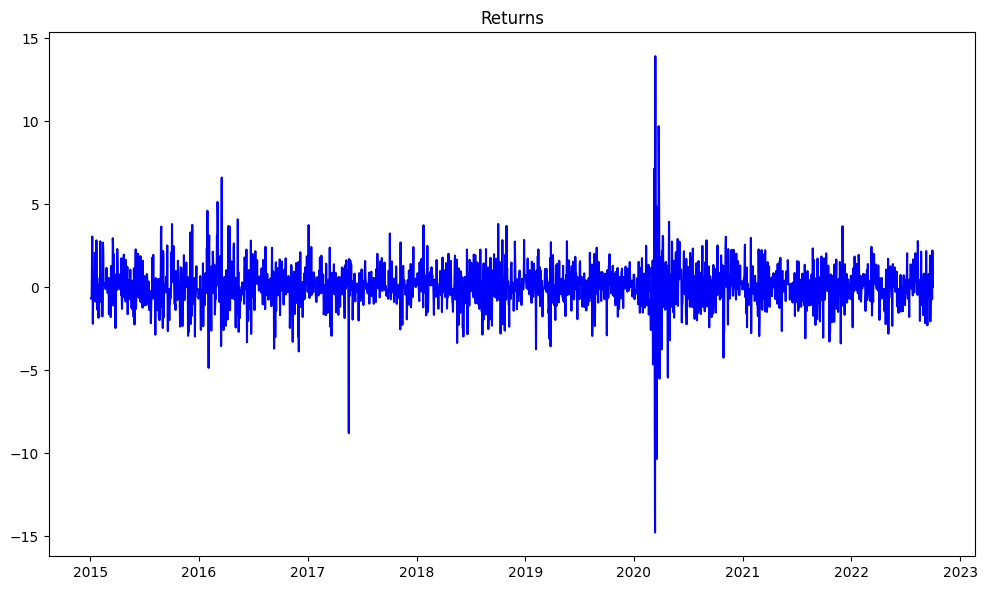

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df['returns'], color='blue')
plt.title('Returns')
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'simple-return.png'), dpi=300, bbox_inches='tight')
fig.show();

In [28]:
df['returns'].describe()

count    2829.000000
mean        0.036237
std         1.204625
min       -14.779679
25%        -0.469901
50%         0.030407
75%         0.527485
max        13.908215
Name: returns, dtype: float64

In [29]:
stats.skew(df['returns'])

-0.325288146454811

In [30]:
stats.kurtosis(df['returns'])

21.330520907659082

In [31]:
df['log_returns'].describe()

count    2829.000000
mean        0.000290
std         0.012085
min        -0.159930
25%        -0.004710
50%         0.000304
75%         0.005261
max         0.130223
Name: log_returns, dtype: float64

In [32]:
stats.skew(df['log_returns'])

-0.7567232111893324

In [33]:
stats.kurtosis(df['log_returns'])


22.964989610235733

In [34]:
shapiro(df['returns'])

ShapiroResult(statistic=0.861548900604248, pvalue=1.6815581571897805e-44)

#### **Returns/Log Returns Estacionariedade**

In [35]:
adfuller_results = adfuller(df['log_returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -11.406949493691155
p-value: 7.409536615508e-21
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [36]:
# RETURNS
adfuller_results = adfuller(df['returns'])

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -11.492677454403072
p-value: 4.6947619802010465e-21
Critical Values:
1%: -3.4327
5%: -2.8626
10%: -2.5673


In [37]:
kpss_results = kpss(df['returns']);
print(kpss_results)

(0.06254910989107305, 0.1, 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\gabriel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Para o nível de significancia com alpha igual a 0.05, o `p-value` de ambos, tanto o Retorno quanto do Log Retorno são menores que o alpha, logo tem-se evidencia suficiente para rejeitar a Hipotese nula.

### Verificar Autocorrelação e Autocorrelação Parcial

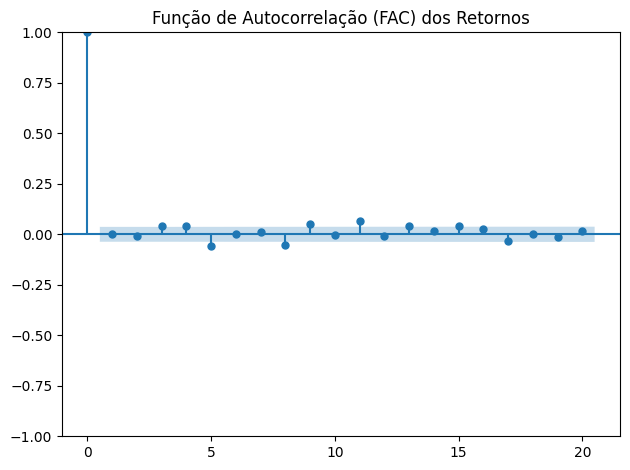

In [38]:
plot_acf(df['returns'], lags=20,  title="Função de Autocorrelação (FAC) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return.jpg'), dpi=300, bbox_inches='tight')

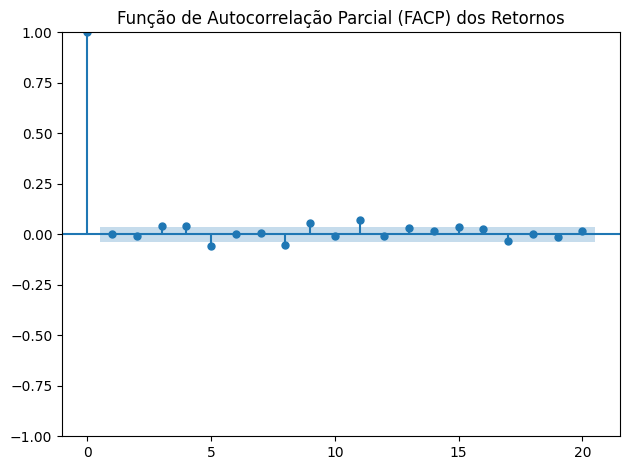

In [39]:
plot_pacf(df['returns'], lags=20, title="Função de Autocorrelação Parcial (FACP) dos Retornos");
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return.jpg'), dpi=300, bbox_inches='tight')

In [40]:
acorr_ljungbox(df['returns'], lags=10)

,lb_stat,lb_pvalue
1,0.029279,0.864137
2,0.359329,0.835550
3,5.642824,0.130341
4,10.477610,0.033107
5,19.516110,0.001540
6,19.521077,0.003368
7,19.781130,0.006062
8,28.266918,0.000426
9,35.645327,0.000046
10,35.665335,0.000096


In [41]:
INTERVAL_WINDOW = 14
n_future = 7

df['vol_current'] = df['log_returns'].rolling(window=INTERVAL_WINDOW)\
  .apply(realized_volatility_daily)

df['vol_future'] = df['log_returns']\
    .shift(-n_future)\
    .rolling(window=INTERVAL_WINDOW)\
      .apply(realized_volatility_daily)


In [42]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,covid,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,,,,
2015-01-03,49507.333333,49507.333333,47984.666667,48180.333333,3210100.0,0.0,0.0,0,-0.683680,-0.006860,NaN,NaN
2015-01-04,49009.666667,49009.666667,47624.333333,47848.666667,3538100.0,0.0,0.0,0,-0.688386,-0.006908,NaN,NaN
2015-01-05,48512.000000,48512.000000,47264.000000,47517.000000,3866100.0,0.0,0.0,0,-0.693158,-0.006956,NaN,NaN
2015-01-06,47517.000000,48061.000000,47338.000000,48001.000000,4559300.0,0.0,0.0,0,1.018583,0.010134,NaN,NaN
2015-01-07,48006.000000,49882.000000,48006.000000,49463.000000,4408800.0,0.0,0.0,0,3.045770,0.030003,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,109122.000000,110161.000000,108120.000000,108376.000000,14517500.0,0.0,0.0,1,-0.676357,-0.006787,0.010137,NaN
2022-09-28,108377.000000,108970.000000,107914.000000,108451.000000,13540500.0,0.0,0.0,1,0.069204,0.000692,0.010120,NaN
2022-09-29,108449.000000,108449.000000,106244.000000,107664.000000,14588500.0,0.0,0.0,1,-0.725673,-0.007283,0.010211,NaN


In [43]:
df.dropna(inplace=True)

Text(0, 0.5, 'Preço Fechamento')

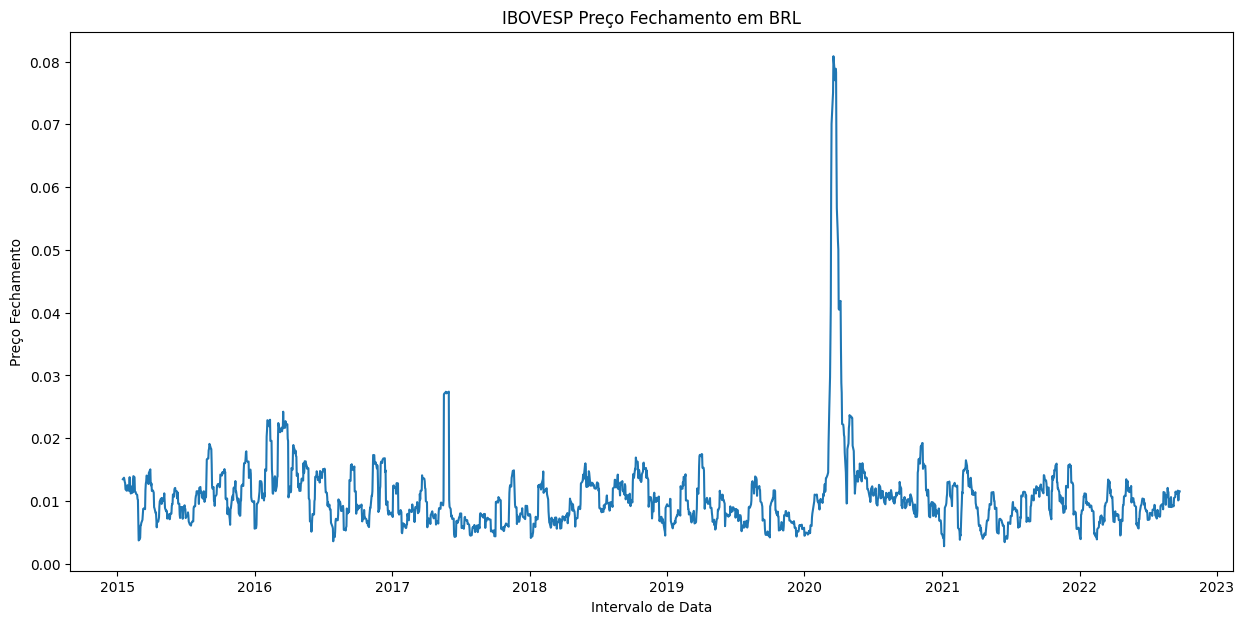

In [44]:
plt.figure(figsize=(15,7))
plt.title('IBOVESP Preço Fechamento em BRL')
plt.plot(df['vol_current'])
plt.xlabel('Intervalo de Data')
plt.ylabel('Preço Fechamento')

### Treino - Teste - Validação 

O dataset será dividido em:
- Os 30 itens finais serão utilizados para teste final.
- 1 ano inteiro para validação e ajustes do modelo
- E o restante para treinamento

In [45]:
test_size = 30
val_size = 365

# INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# PARA DIVIDIR O DATASET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [46]:
print(f'Training \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2015-01-16 00:00:00 	to: 2021-08-25 00:00:00 	2414 days
Validation 	From: 2021-08-26 00:00:00 	to: 2022-08-25 00:00:00 	365 days
Test 		From: 2022-08-26 00:00:00 	to: 2022-09-24 00:00:00 	30 days


In [47]:
y_train = df['vol_future'][train_idx]
y_val = df['vol_future'][val_idx]
y_test = df['vol_future'][test_idx]

In [48]:
x_train = df['vol_current'][train_idx]
x_val = df['vol_current'][val_idx]
x_test = df['vol_current'][test_idx]

In [49]:
r_train = df['returns'][train_idx]
r_val = df['returns'][val_idx]
r_test = df['returns'][test_idx]

In [50]:
lr_train = df['log_returns'][train_idx]
lr_val = df['log_returns'][val_idx]
lr_test = df['log_returns'][test_idx]

In [51]:
covid_train = df['covid'][train_idx]
covid_val = df['covid'][val_idx]

### Normalizar os dados

In [52]:
scaler_vol = StandardScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [53]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

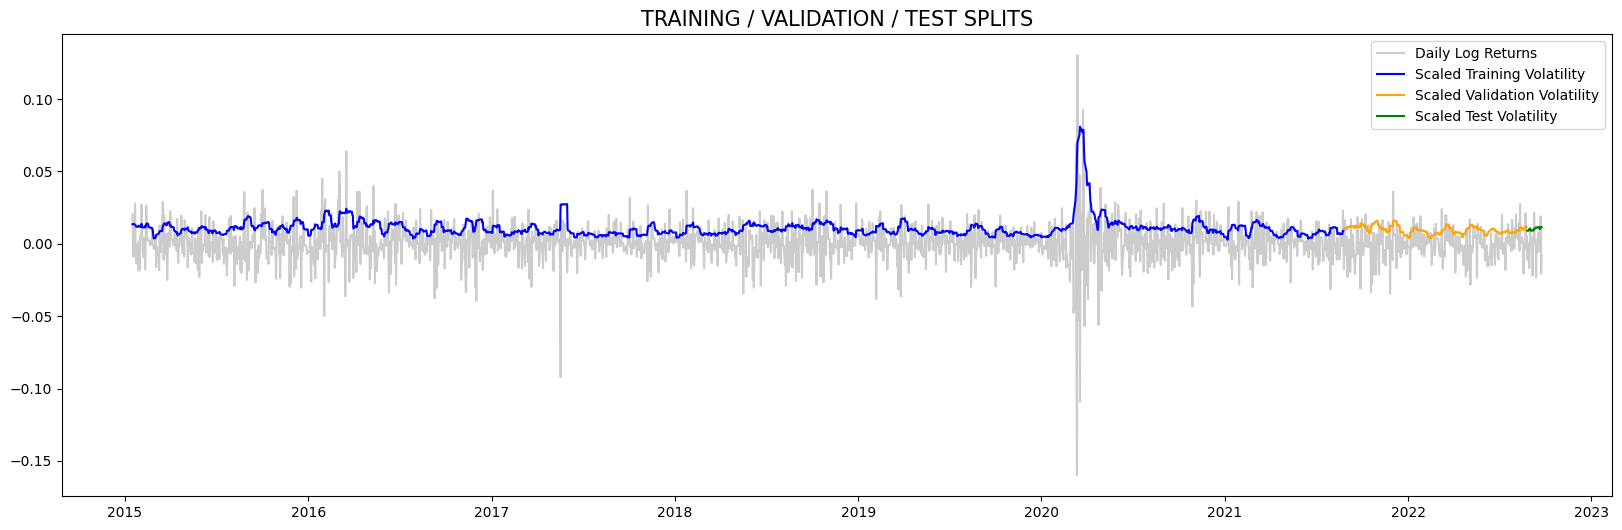

In [54]:
plt.figure(figsize=(20,6))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(x_train, color='blue', label='Scaled Training Volatility')
plt.plot(x_val, color='orange', label='Scaled Validation Volatility')
plt.plot(x_test, color='green', label='Scaled Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS', 
          fontsize=15)
plt.legend(frameon=True)
plt.savefig(os.path.join(img_dir, 'train_val_test.jpg'), dpi=300, bbox_inches='tight')
plt.show();

### GARCH MODELS

some Util links
- https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html
- https://users.metu.edu.tr/home402/ozancan/wwwhome/ARCHGARCHTutorial.html
- https://bibliotecadigital.fgv.br/dspace/bitstream/handle/10438/10014/TD%20313%20-%20CEQEF%2003%20-%20Marcos%20Vinicio%20Wink%20Junior%20e%20%20Pedro%20Valls.pdf?sequence=1
- https://repositorio.ufc.br/bitstream/riufc/39729/1/2018_tcc_wlalves.pdf
- file:///C:/Users/Gabriel/Downloads/paulo%20thomaz.pdf

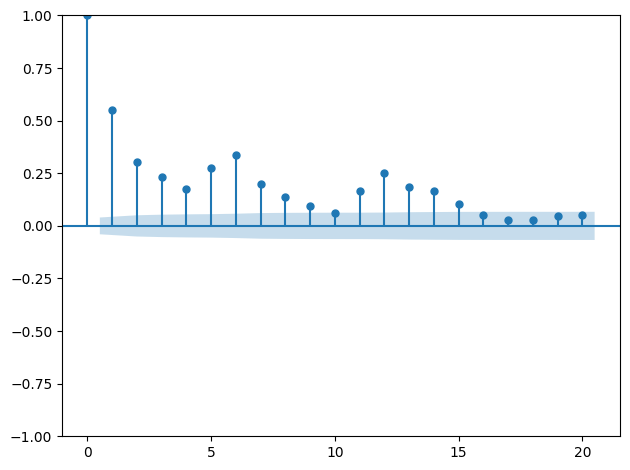

In [55]:
plot_acf(r_train**2,lags=20, title="");
        #   title='Função de Autocorrelação (FAC) do quadrado dos Retornos');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'fac-return-squared.jpg'), dpi=300, bbox_inches='tight')

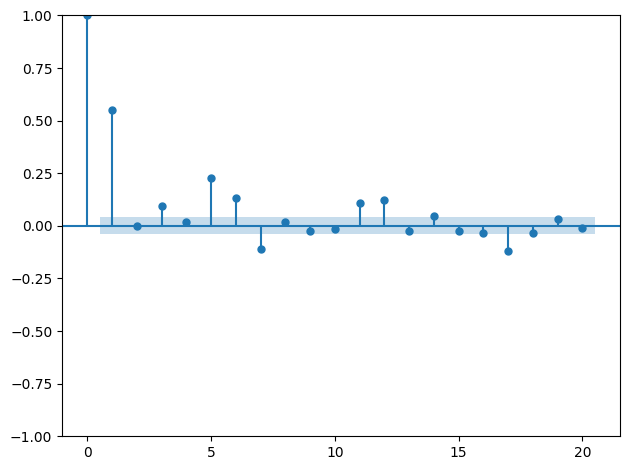

In [56]:
plot_pacf(r_train**2, lags=20, title="")
        #   title='Função de Autocorrelação Parcial (FACP) do quadrado dos Retornos\n(Treinamento)');
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'facp-return-squared.jpg'), dpi=300, bbox_inches='tight')

Verifica-se pelo quadrado dos retornos que o modelo ARCH é adaquado

### GARCH

In [58]:
from arch import arch_model

In [59]:
gm_22 = arch_model(r_train, p=2, q=2)
result_22 = gm_22.fit(disp='off')
gm_11 = arch_model(r_train, p=1, q=1)
result_11 = gm_11.fit(disp='off')
gm_21 = arch_model(r_train, p=2, q=1)
result_21 = gm_21.fit(disp='off')
gm_12 = arch_model(r_train, p=1, q=2)
result_12 = gm_12.fit(disp='off')

gm_10 = arch_model(r_train, p=1, q=0)
result_10 = gm_10.fit(disp='off')

In [60]:
result_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3564.10
Distribution:                  Normal   AIC:                           7136.21
Method:            Maximum Likelihood   BIC:                           7159.37
                                        No. Observations:                 2414
Date:                Thu, Mar 16 2023   Df Residuals:                     2413
Time:                        16:04:52   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0726  2.174e-02      3.339  8.415e-04 [2.998e-02,  0.115]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0697  4.059e-02      1.718  8.573e-02 [-9.807e-03,  0.149]
alpha[1]       0.0823  2.838e-02      2.901  3.718e-03  [2.671e-02,  0.138]
beta[1]        0.8616  5.610e-02     15.358  3.144e-53    [  0.752,  0.972]
===========================================================================

Covariance estimator: robust
"""

In [61]:
log_garch(result_11, "GARCH (1,1) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7136.209967,7159.366129,0.203015,0.000008,0.000097,7.193852e-28


Utilizando nivel de significande de 0.05, nenhum dos coefieficientes para os modelos (1,2), (2,1), (2,2) parecem ser estatisticamente significante, já que o os seus p-values `P > |t|` são todos maiores que 0.05. diferente do GARCH (1,1)

É possivel verificar que que pelo test `Shapiro Wilk (SW)`, `p-value` é menor que 0.05, portanto é rejeita-se a hipotese nula e assim, temos evidencia suficiente para dizer que não segue uma distribuição normal, o que é comum para series financeiras, porém o modelo garch permite setar a distribuição como T Student , 

In [63]:
gm_student_11 = arch_model(r_train, p=1, q=1, dist="StudentsT")
result_student_11 = gm_student_11.fit(disp='off')
gm_student_22 = arch_model(r_train, p=2, q=2, dist="StudentsT")
result_student_22 = gm_student_22.fit(disp='off')
gm_student_12 = arch_model(r_train, p=1, q=2, dist="StudentsT")
result_student_12 = gm_student_12.fit(disp='off')
gm_student_21 = arch_model(r_train, p=2, q=1, dist="StudentsT")
result_student_21 = gm_student_21.fit(disp='off')

In [64]:
result_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3371.81
Distribution:      Standardized Student's t   AIC:                           6753.61
Method:                  Maximum Likelihood   BIC:                           6782.56
                                              No. Observations:                 2414
Date:                      Thu, Mar 16 2023   Df Residuals:                     2413
Time:                              16:05:01   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0576  1.580e-02      3.643  2.692e-04 [2.659e-02,8.852e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0613  3.265e-02      1.878  6.041e-02 [-2.684e-03,  0.125]
alpha[1]       0.0893  3.335e-02      2.677  7.437e-03  [2.390e-02,  0.155]
beta[1]        0.8966  4.037e-02     22.211 2.707e-109    [  0.818,  0.976]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.8631      0.187     15.339  4.183e-53 [  2.497,  3.229]
========================================================================

Covariance estimator: robust
"""

In [65]:
log_garch(result_student_11, "GARCH (1,1) - Student", False)

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7136.209967,7159.366129,0.203015,0.000008,0.000097,7.193852e-28
"GARCH (1,1) - Student",6753.614473,6782.559675,0.214600,0.000007,0.000078,0.000000e+00


In [66]:
scaler_garch_11, scaled_cond_vol_11 = scale_tf_cond_vol(result_11)

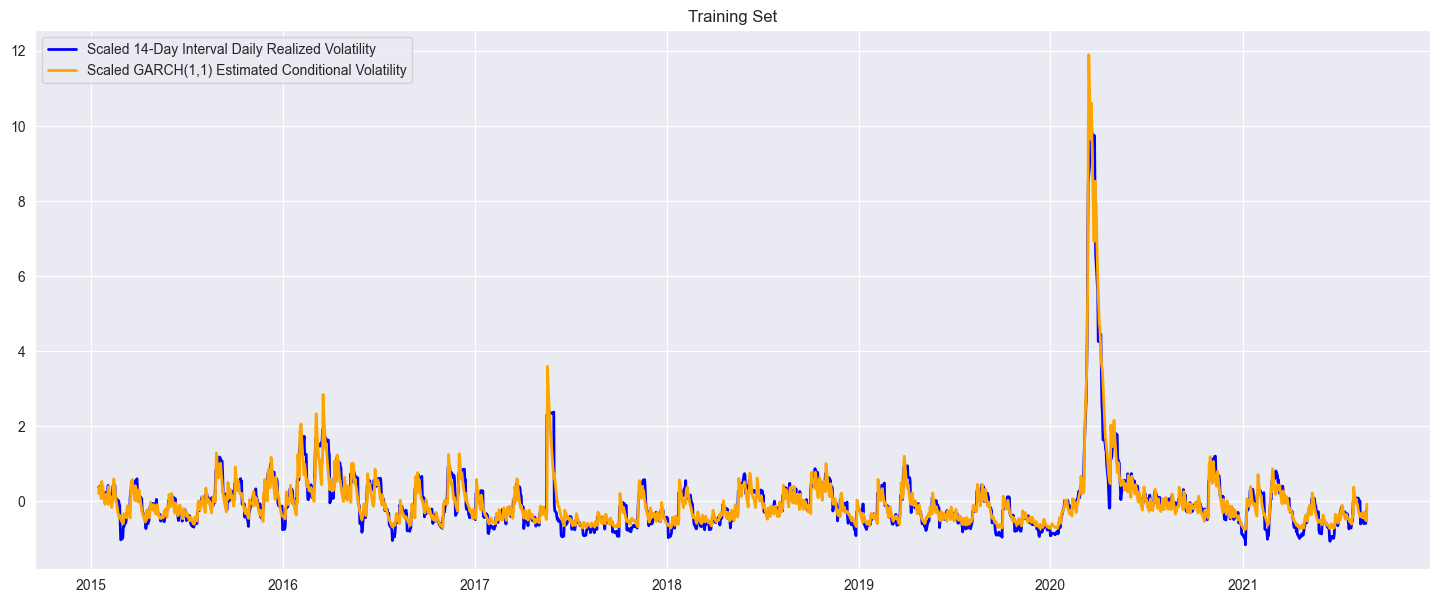

In [67]:
viz_cond_vol(scaled_cond_vol_11, 'GARCH(1,1)')

### Expanding Window Forecasting

Será dada a previsão para os próximo dias futuros `n_future = 14` e assim deve-se reajustar o modelo para cada passo no tempo.


In [68]:
def expading_window_forecast_garch(arch_model):
    size = len(val_idx)
    rolling_forecasts = []
    idx = df.index
    # Set de validação
    for i in range(0, size, 1):
    # Pegar os valores anteriores a esse step
        idx = val_idx[i]
        train = df.returns[:idx]
        # treinar o modelo até esse step
        model = arch_model(train)
        model_fit = model.fit(disp='off')
        # fazer a predição com n_future 
        values = model_fit.forecast(horizon=1, 
                             reindex=False).variance.iloc[0]
        for value in values:
            rolling_forecasts.append(value)
    values_forecast = []
    for i in range(size):
        values_forecast.append(rolling_forecasts[i]**.5)
    return pd.Series(values_forecast, index=val_idx)

In [69]:
gm_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1) )

In [70]:
gm_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_11, gm_11_preds)

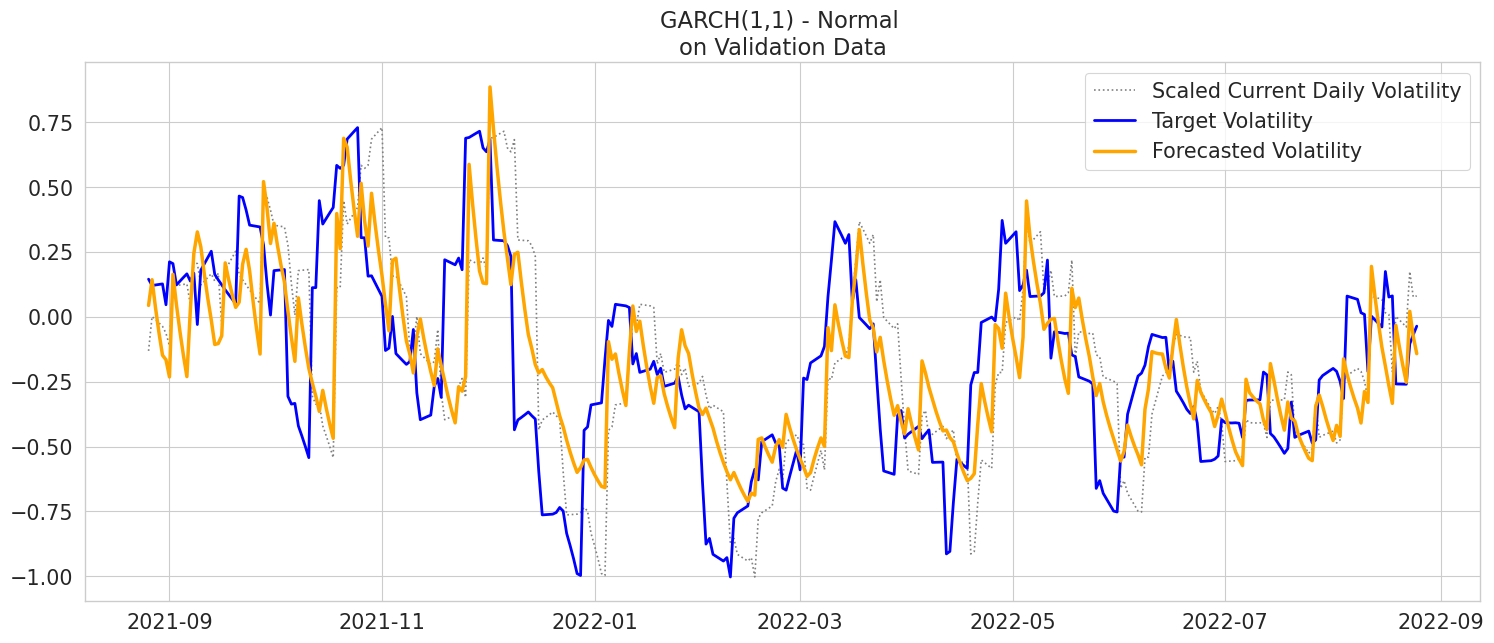

In [71]:
viz_model(y_val_scaled, gm_11_preds_scaled, 'GARCH(1,1) - Normal')

In [72]:
log_perf(y_val_scaled, gm_11_preds_scaled,'GARCH(1,1) - Normal')

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",33.810183,0.278488,4.132351


In [73]:
gm_student_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, vol='GARCH', p=1, q=1, dist="StudentsT") )
scaler_garch_student_11, scaled_cond_vol_student_11 = scale_tf_cond_vol(result_student_11)
gm_student_11_preds_scaled = transform_volatility_to_scaler(scaler_garch_student_11, gm_student_11_preds)
log_perf(y_val_scaled, gm_student_11_preds_scaled,'GARCH(1,1) - Student')

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",33.810183,0.278488,4.132351
"GARCH(1,1) - Student",36.171421,0.289224,4.192053


### Garch Model with asymmetric shock response

In [74]:
gjr_gm_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH')
result_gjr_gm_11 = gjr_gm_11.fit(disp='off')
gjr_gm_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH')
result_gjr_gm_22 = gjr_gm_22.fit(disp='off')
gjr_gm_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH')
result_gjr_gm_21 = gjr_gm_21.fit(disp='off')
gjr_gm_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH')
result_gjr_gm_12 = gjr_gm_12.fit(disp='off')

In [75]:
result_gjr_gm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3554.39
Distribution:                  Normal   AIC:                           7118.79
Method:            Maximum Likelihood   BIC:                           7147.73
                                        No. Observations:                 2414
Date:                Thu, Mar 16 2023   Df Residuals:                     2413
Time:                        16:13:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0607  2.132e-02      2.846  4.422e-03 [1.890e-02,  0.102]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0638  3.837e-02      1.664  9.610e-02   [-1.135e-02,  0.139]
alpha[1]       0.0393  2.151e-02      1.825  6.800e-02 [-2.904e-03,8.143e-02]
gamma[1]       0.0795  3.956e-02      2.008  4.460e-02    [1.915e-03,  0.157]
beta[1]        0.8700  5.592e-02     15.559  1.379e-54      [  0.760,  0.980]
=============================================================================

Covariance estimator: robust
"""

In [76]:
log_garch(result_gjr_gm_11, "GJR-GARCH (1,1) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7136.209967,7159.366129,0.203015,0.000008,0.000097,7.193852e-28
"GARCH (1,1) - Student",6753.614473,6782.559675,0.214600,0.000007,0.000078,0.000000e+00
"GJR-GARCH (1,1) - Normal",7118.789003,7147.734205,0.153044,0.000004,0.000054,6.380868e-28


In [77]:
gjr_gm_student_11 = arch_model(r_train, p=1, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_11 = gjr_gm_student_11.fit(disp='off')
gjr_gm_student_22 = arch_model(r_train, p=2, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_22 = gjr_gm_student_22.fit(disp='off')
gjr_gm_student_21 = arch_model(r_train, p=2, q=1, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_21 = gjr_gm_student_21.fit(disp='off')
gjr_gm_student_12 = arch_model(r_train, p=1, q=2, o=1, vol='GARCH', dist='StudentsT')
result_gjr_gm_student_12 = gjr_gm_student_12.fit(disp='off')

In [78]:
result_gjr_gm_student_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3359.38
Distribution:      Standardized Student's t   AIC:                           6730.77
Method:                  Maximum Likelihood   BIC:                           6765.50
                                              No. Observations:                 2414
Date:                      Thu, Mar 16 2023   Df Residuals:                     2413
Time:                              16:13:12   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0525  1.551e-02      3.384  7.139e-04 [2.210e-02,8.291e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0663  2.480e-02      2.675  7.465e-03    [1.774e-02,  0.115]
alpha[1]       0.0237  1.872e-02      1.268      0.205 [-1.295e-02,6.044e-02]
gamma[1]       0.1541  5.138e-02      2.999  2.710e-03    [5.337e-02,  0.255]
beta[1]        0.8871  3.042e-02     29.158 6.662e-187      [  0.827,  0.947]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.8817      0.188     15.361  3.011e-53 [  2.514,  3.249]
========================================================================

Covariance estimator: robust
"""

In [79]:
log_garch(result_gjr_gm_student_11, "GJR-GARCH (1,1) - Student")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7136.209967,7159.366129,0.203015,0.000008,0.000097,7.193852e-28
"GARCH (1,1) - Student",6753.614473,6782.559675,0.214600,0.000007,0.000078,0.000000e+00
"GJR-GARCH (1,1) - Normal",7118.789003,7147.734205,0.153044,0.000004,0.000054,6.380868e-28
"GJR-GARCH (1,1) - Student",6730.769257,6765.503499,0.114937,0.000003,0.000047,2.509667e-28


### TARCH

In [80]:

np.random.seed(seed)
t_gm_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0, dist='normal')
result_t_gm_11 = t_gm_11.fit(disp='off')
t_gm_22 = arch_model(r_train, p=2, o=1, q=2, power=1.0, dist='normal')
result_t_gm_22 = t_gm_22.fit(disp='off')
t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0, dist='normal')
result_t_gm_21 = t_gm_21.fit(disp='off')
t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0, dist='normal')
result_t_gm_12 = t_gm_12.fit(disp='off')

In [81]:
result_t_gm_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Constant Mean - TARCH/ZARCH Model Results                   
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -3561.94
Distribution:                  Normal   AIC:                           7133.88
Method:            Maximum Likelihood   BIC:                           7162.83
                                        No. Observations:                 2414
Date:                Thu, Mar 16 2023   Df Residuals:                     2413
Time:                        16:13:16   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0429  2.567e-02      1.673  9.439e-02 [-7.374e-03,9.324e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.6830  5.711e-02     11.960  5.731e-33    [  0.571,  0.795]
alpha[1]       0.3386  4.930e-02      6.867  6.534e-12    [  0.242,  0.435]
gamma[1]       0.1026  7.026e-02      1.460      0.144 [-3.509e-02,  0.240]
beta[1]        0.1069  5.781e-02      1.850  6.436e-02 [-6.374e-03,  0.220]
===========================================================================

Covariance estimator: robust
"""

In [82]:
log_garch(result_t_gm_11, "TARCH (1,1) - Normal")

,AIC,BIC,LB,LB(r²),ARCH,SW
"GARCH (1,1) - Normal",7136.209967,7159.366129,0.203015,7.941838e-06,9.684388e-05,7.193852e-28
"GARCH (1,1) - Student",6753.614473,6782.559675,0.214600,7.111645e-06,7.843312e-05,0.000000e+00
"GJR-GARCH (1,1) - Normal",7118.789003,7147.734205,0.153044,3.716900e-06,5.379448e-05,6.380868e-28
"GJR-GARCH (1,1) - Student",6730.769257,6765.503499,0.114937,3.498303e-06,4.687767e-05,2.509667e-28
"TARCH (1,1) - Normal",7133.880425,7162.825627,0.127211,7.038800e-15,2.035760e-15,3.287458e-29


In [83]:
# t_11_preds = expading_window_forecast_garch(lambda train: arch_model(train, p=1, o=1, q=1, power=1.0) )
# scaler_tarch_11, scaled_tarch_cond_vol_11 = scale_tf_cond_vol(result_student_11)
# t_11_preds_scaled = transform_volatility_to_scaler(scaler_tarch_11, t_11_preds)

In [84]:
e_gm_11 = arch_model(r_train, vol='EGARCH', p=1, o=1, q=1, power=1.0, dist='normal')
result_e_gm_11 = e_gm_11.fit(disp='off')
print(result_e_gm_11.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3548.76
Distribution:                  Normal   AIC:                           7107.53
Method:            Maximum Likelihood   BIC:                           7136.47
                                        No. Observations:                 2414
Date:                Thu, Mar 16 2023   Df Residuals:                     2413
Time:                        16:13:19   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0560  3.395e-03     16.479  5.216e-61 [4.

In [ ]:

np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=1, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

In [ ]:

np.random.seed(seed)

t_gm_21 = arch_model(r_train, p=2, o=1, q=1, power=1.0,
                  dist='skewt')
result_gm_21 = t_gm_21.fit(disp='off')
print(result_gm_21.summary())

In [ ]:

np.random.seed(seed)

t_gm_12 = arch_model(r_train, p=2, o=1, q=2, power=1.0,
                  dist='skewt')
result_gm_12 = t_gm_12.fit(disp='off')
print(result_gm_12.summary())

In [ ]:

np.random.seed(seed)

t_gm_student_11 = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='t')
result_gm_student_11 = t_gm_student_11.fit(disp='off')
print(result_gm_student_11.summary())

### REDES NEURAIS

In [85]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [86]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return tf.convert_to_tensor(dataX), tf.convert_to_tensor(dataY)

In [87]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [88]:
# Forecast RNN
def forecast(model, range_idx, n_past):
    start_idx = range_idx[0] - timedelta(n_past -1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [89]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

In [90]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [106]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

In [107]:
snn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [108]:
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

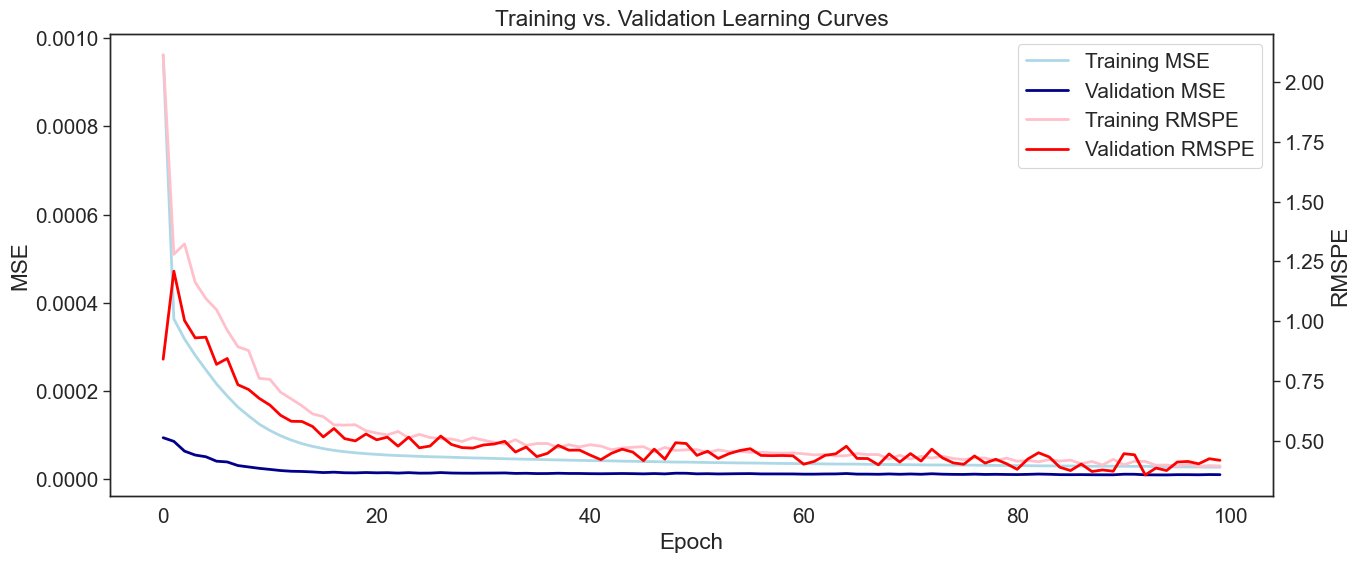

In [109]:
viz_train_val_metrics(snn_1_res)

In [111]:
snn_1_preds = forecast(snn_1, val_idx, n_past=n_past)
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 883us/step


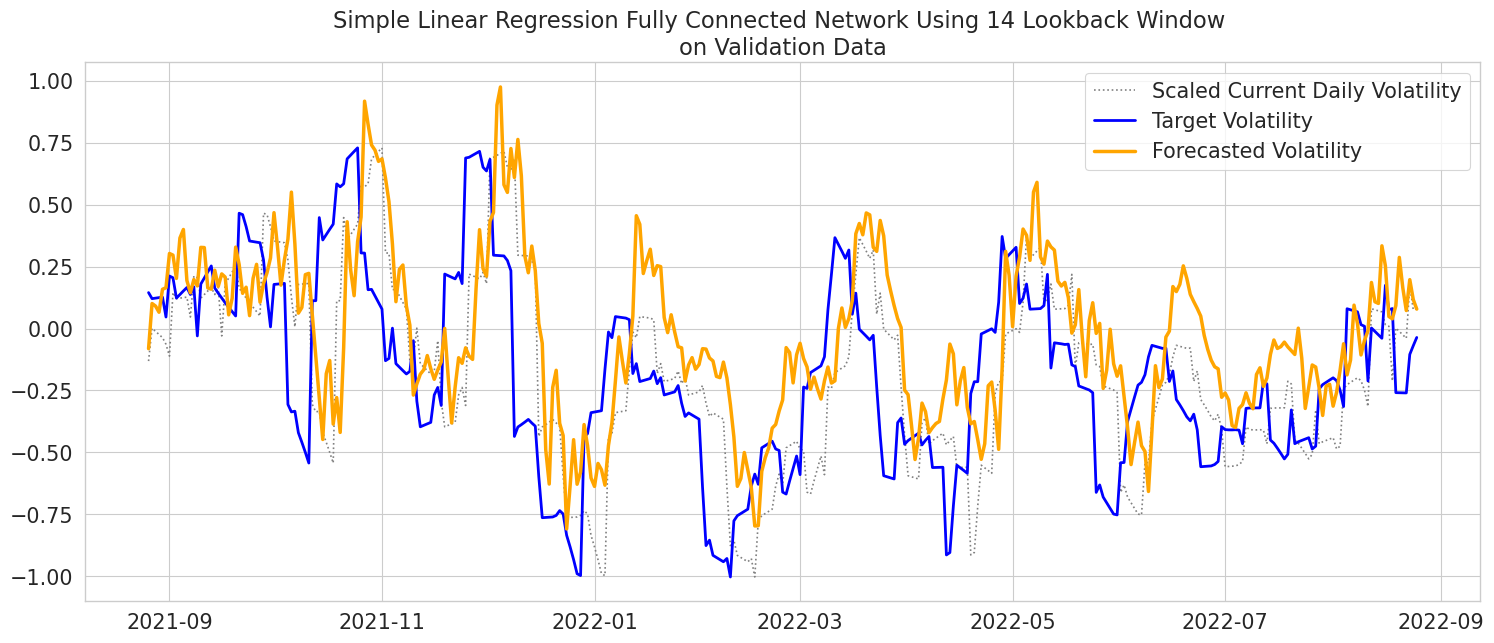

In [112]:
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'fully_connected_NN.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [97]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",33.810183,0.278488,4.132351
"GARCH(1,1) - Student",36.171421,0.289224,4.192053
"Simple LR Fully Connected NN, n_past=14",22.110758,0.311236,3.371984


In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

### LSTM


In [113]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

In [125]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64
mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [126]:
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=100)

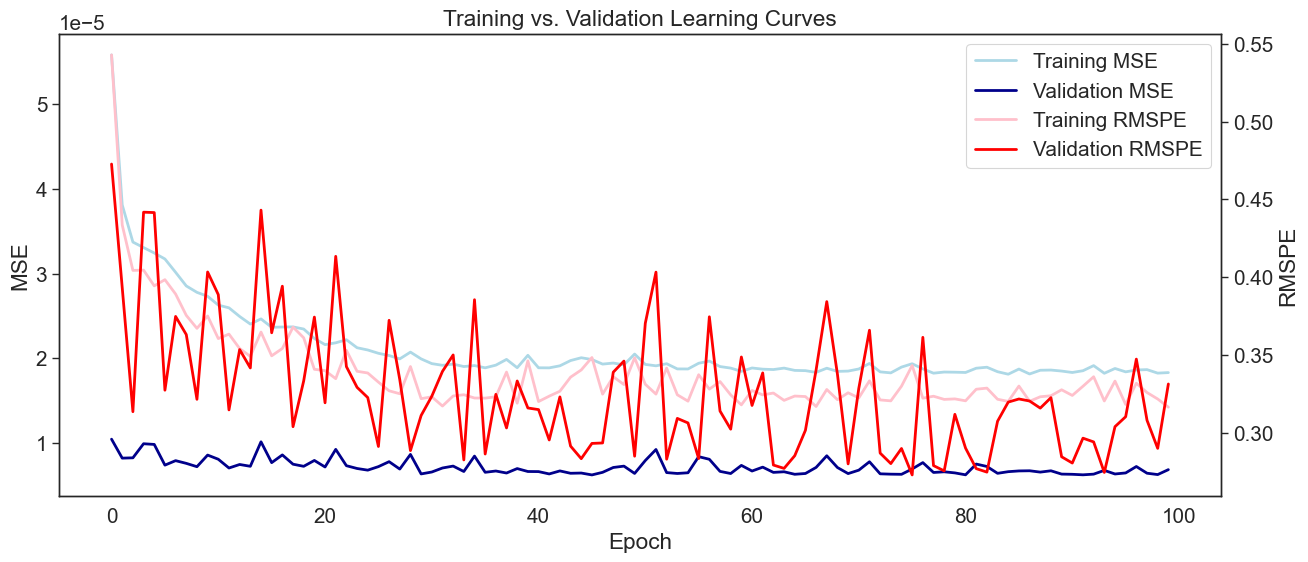

In [127]:
viz_train_val_metrics(lstm_1_res)

In [117]:
lstm_1_preds = forecast(lstm_1, val_idx, n_past=n_past)
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 0s 4ms/step


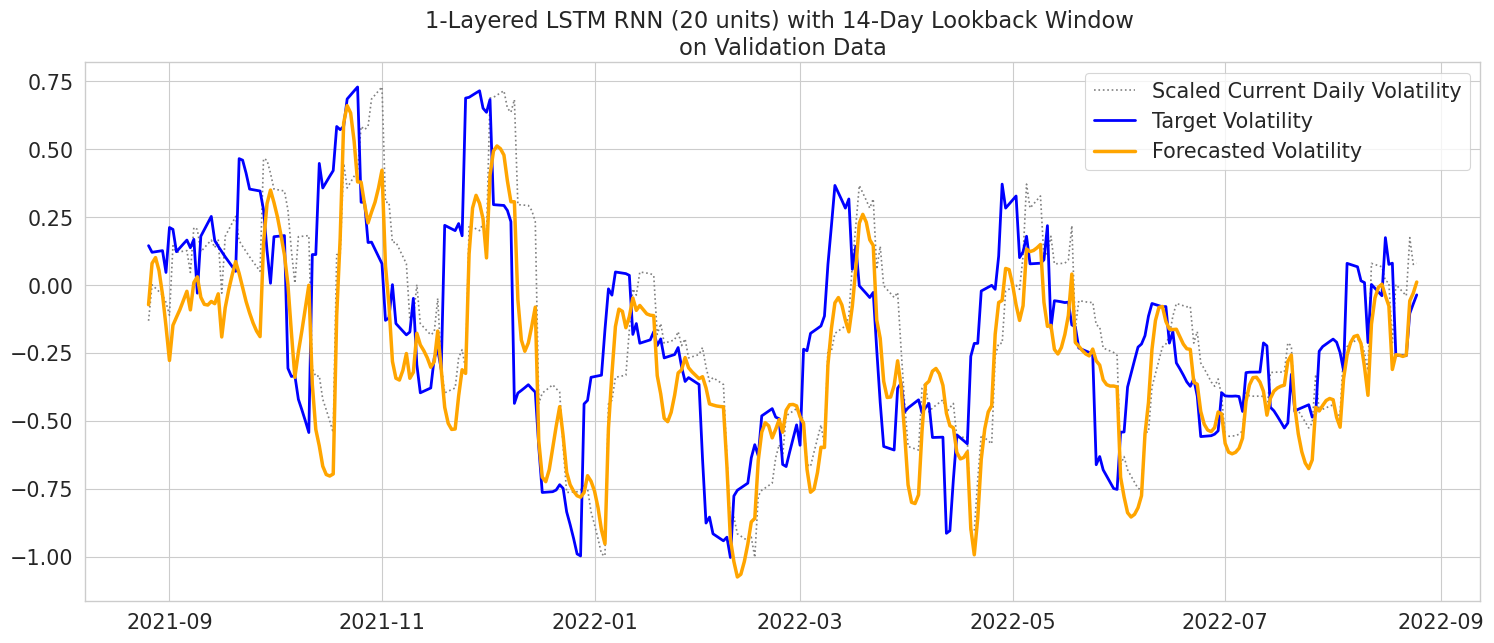

In [118]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'lstm_1.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [119]:
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",33.810183,0.278488,4.132351
"GARCH(1,1) - Student",36.171421,0.289224,4.192053
"Simple LR Fully Connected NN, n_past=14",22.110758,0.311236,3.371984
"LSTM 1 layer 20 units, n_past=14",33.925002,0.311832,4.338794


In [128]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________


In [129]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

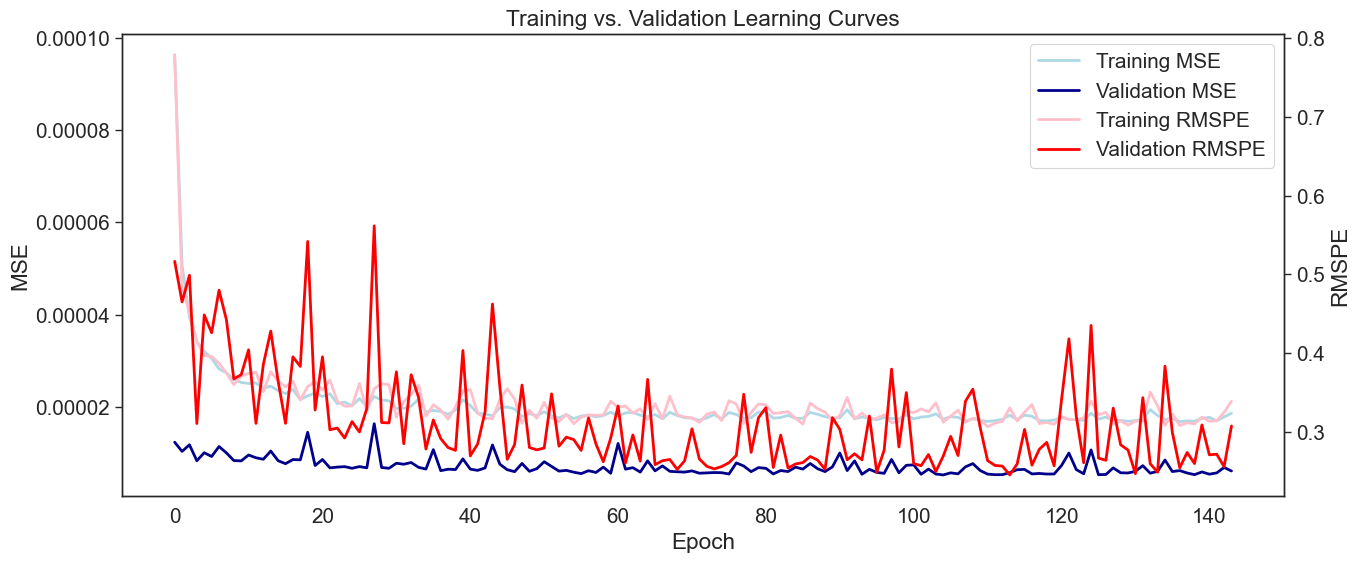

In [137]:
viz_train_val_metrics(lstm_2_res)


In [133]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx,  n_past=n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 2s 6ms/step


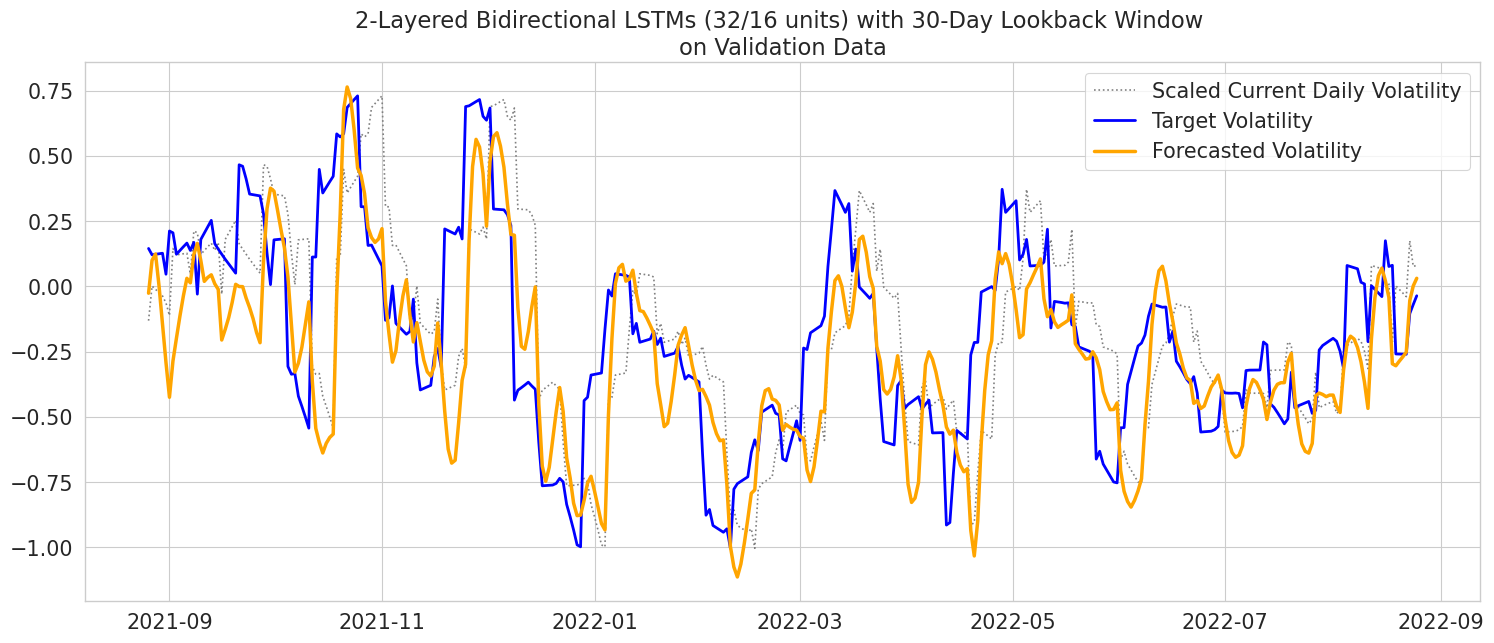

In [134]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
# plt.savefig(os.path.join(directory_to_img, 'lstm_2.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [135]:
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units) | n_past={n_past}")

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",33.810183,0.278488,4.132351
"GARCH(1,1) - Student",36.171421,0.289224,4.192053
"Simple LR Fully Connected NN, n_past=14",22.110758,0.311236,3.371984
"LSTM 1 layer 20 units, n_past=14",33.925002,0.311832,4.338794
2 layers Bidirect LSTM (32/16 units) | n_past=30,18.837320,0.297164,3.273421


In [145]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27,201
Trainable params: 27,201
Non-traina

In [146]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
38/38 [==============================] - 7s 31ms/step - loss: 5.3485e-05 - rmspe: 0.5420 - val_loss: 1.4734e-05 - val_rmspe: 0.5813
Epoch 2/200
38/38 [==============================] - 1s 14ms/step - loss: 4.5545e-05 - rmspe: 0.4869 - val_loss: 6.2525e-06 - val_rmspe: 0.3537
Epoch 3/200
38/38 [==============================] - 1s 13ms/step - loss: 4.3118e-05 - rmspe: 0.4816 - val_loss: 6.3858e-06 - val_rmspe: 0.3599
Epoch 4/200
38/38 [==============================] - 0s 13ms/step - loss: 4.1019e-05 - rmspe: 0.4603 - val_loss: 1.0313e-05 - val_rmspe: 0.4811
Epoch 5/200
38/38 [==============================] - 0s 13ms/step - loss: 3.9493e-05 - rmspe: 0.4611 - val_loss: 2.1781e-05 - val_rmspe: 0.6837
Epoch 6/200
38/38 [==============================] - 1s 15ms/step - loss: 3.9497e-05 - rmspe: 0.4903 - val_loss: 6.3607e-06 - val_rmspe: 0.2906
Epoch 7/200
38/38 [==============================] - 1s 13ms/step - loss: 3.5408e-05 - rmspe: 0.4464 - val_loss: 2.0579e-05 - val_rmspe:

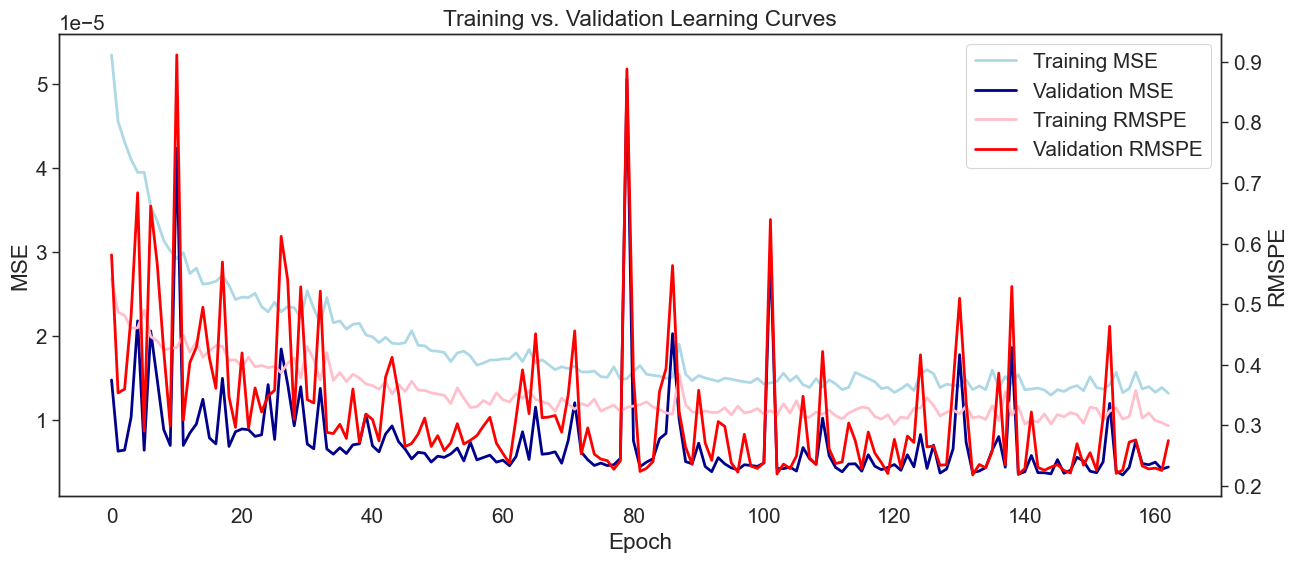

In [147]:
viz_train_val_metrics(lstm_3_res)

In [148]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx, n_past)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 1s 3ms/step


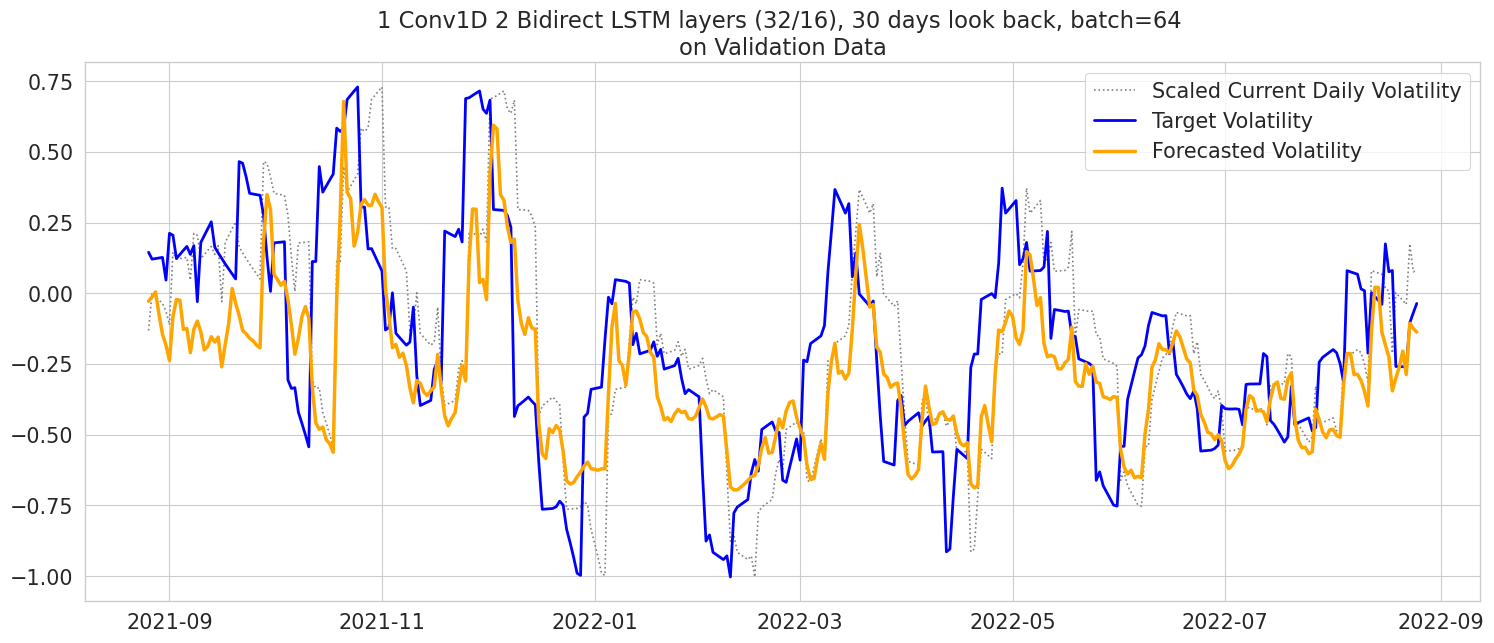

In [149]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
# plt.savefig(os.path.join(directory_to_img, 'lstm_3.png'), 
#             dpi=300, bbox_inches='tight')
plt.show();

In [150]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

,Validation RMSPE,Validation RMSE,MAPE
"GARCH(1,1) - Normal",33.810183,0.278488,4.132351
"GARCH(1,1) - Student",36.171421,0.289224,4.192053
"Simple LR Fully Connected NN, n_past=14",22.110758,0.311236,3.371984
"LSTM 1 layer 20 units, n_past=14",33.925002,0.311832,4.338794
2 layers Bidirect LSTM (32/16 units) | n_past=30,18.837320,0.297164,3.273421
"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=60, batch=64",38.978733,0.420654,5.954301
"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",38.951899,0.304101,4.475656
